## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from core.loader import Loader

from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


2025-04-26 20:23:54.982817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-26 20:23:54.982853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-26 20:23:55.013168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 20:23:55.083518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-26 20:23:56.110157: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-04-26 20:23:59.539030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-26 20:23:59.675615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-26 20:23:59.678626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Load input datasets

In [ ]:


# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign/benign_2312_anonymized_HTML.parquet', 
    'parkets/benign/umbrella_benign_FINISHED_HTML.parquet'
        
]
malicious_dataset_filenames = [
    'parkets/phishing_2406_strict_HTML.parquet'
]

# lex-dga-830k-pick.parquet LABEL je jmeno rodiny
#  'parkets/malware_2406_strict_HTML.parquet'


# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

class_map = {benign_label: 0, malicious_label: 1}
# print labels from malicious datasets

loader = Loader(benign_dataset_filenames, malicious_dataset_filenames, benign_label=benign_label, malicious_label=malicious_label, subsample=0.05)
df = loader.load()



### Generate subsets of the training dataset

In [6]:
import pandas as pd

# Define prefixes
prefixes = ["dns_", "tls_", "html_", "geo_", "rdap_", "lex_", "ip_"]

# Dictionary to store filtered datasets
subset_dfs = {}

# Create subsets for each prefix
for prefix in prefixes:
    subset_df = df.loc[:, df.columns.str.startswith(prefix) | df.columns.isin(['label'])]
    
    # Store in dictionary
    subset_dfs[prefix] = subset_df

    print(f"Subset '{prefix}' contains {subset_df.shape[1]} features and {subset_df.shape[0]} samples.")
    # print all columns in the subset
    print(subset_df.columns)
    
    
    
## Agregations 

# agregate dns and rdap features and append to prefixes 


Subset 'dns_' contains 41 features and 45857 samples.
Index(['label', 'dns_has_dnskey', 'dns_A_count', 'dns_AAAA_count',
       'dns_MX_count', 'dns_NS_count', 'dns_TXT_count', 'dns_SOA_count',
       'dns_CNAME_count', 'dns_zone_level', 'dns_zone_digit_count',
       'dns_zone_len', 'dns_zone_entropy', 'dns_resolved_record_types',
       'dns_dnssec_score', 'dns_ttl_avg', 'dns_ttl_stdev', 'dns_ttl_low',
       'dns_ttl_mid', 'dns_ttl_distinct_count', 'dns_soa_primary_ns_level',
       'dns_soa_primary_ns_digit_count', 'dns_soa_primary_ns_len',
       'dns_soa_primary_ns_entropy', 'dns_soa_email_level',
       'dns_soa_email_digit_count', 'dns_soa_email_len',
       'dns_soa_email_entropy', 'dns_soa_refresh', 'dns_soa_retry',
       'dns_soa_expire', 'dns_soa_min_ttl', 'dns_domain_name_in_mx',
       'dns_mx_avg_len', 'dns_mx_avg_entropy', 'dns_txt_avg_len',
       'dns_txt_avg_entropy', 'dns_txt_external_verification_score',
       'dns_txt_spf_exists', 'dns_txt_dkim_exists', 'dns_txt

#### Aggregations

In [7]:
import pandas as pd
subset_dfs = {}
# Define the list of aggregates
aggregates = [
    ["lex_"],                                                   # 1. step
    ["lex_", "dns_", "ip_"],
    ["lex_", "dns_", "ip_", "geo_"],                            # 2. step
    ["lex_", "dns_", "ip_", "tls_", "geo_"],
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_"],
    ["lex_", "dns_", "ip_", "tls_", "geo_", "rdap_", "html_"]   # 3. step
]






# Process each aggregation group
for group in aggregates:
    # Build a regex pattern to match any of the prefixes in the group
    pattern = '|'.join(f'^{prefix}' for prefix in group)

    # Select columns starting with any of the specified prefixes or the 'label' column
    subset_df = df.loc[:, df.columns.str.contains(pattern) | (df.columns == 'label')]

    # Ensure 'index' column is not included
    subset_df = subset_df.loc[:, ~subset_df.columns.str.contains('^index$', case=False)]

    # Reset index without adding it as a column
    subset_df.reset_index(drop=True, inplace=True)

    # Create a unique key for the aggregated data
    key = '+'.join(group) + "_agg"

    # Store the aggregated DataFrame in the dictionary
    subset_dfs[key] = subset_df

# Iterate over subsets_df and print the number of benign and malicious samples
for key, subset_df in subset_dfs.items():
    print(f"Subset '{key}' contains {subset_df.shape[1]} features and {subset_df.shape[0]} samples.")
    # Print all column names to verify index removal


Subset 'lex__agg' contains 63 features and 45857 samples.
Subset 'lex_+dns_+ip__agg' contains 111 features and 45857 samples.
Subset 'lex_+dns_+ip_+geo__agg' contains 129 features and 45857 samples.
Subset 'lex_+dns_+ip_+tls_+geo__agg' contains 153 features and 45857 samples.
Subset 'lex_+dns_+ip_+tls_+geo_+rdap__agg' contains 177 features and 45857 samples.
Subset 'lex_+dns_+ip_+tls_+geo_+rdap_+html__agg' contains 264 features and 45857 samples.


### Pycarrect

In [8]:
from pycaret.classification import *
import pandas as pd

# Dictionary to store the top 3 models and results grids for each feature subset
top3_models = {}
results_grids = {}

# Iterate through each subset and train models
for prefix, subset_df in subset_dfs.items():
    print(f"\n🔍 Running model comparison for '{prefix}' features...")

    # PyCaret Setup
    clf = setup(subset_df, target='label', session_id=54, log_experiment=False, experiment_name=f'exp_{prefix}', use_gpu=True, train_size=0.8, index=False)
    
    # Compare models and capture the top 3 models
    top_models = compare_models(sort='F1', n_select=3)
    
    # Store the top 3 models
    top3_models[prefix] = top_models
    
    # Pulling the last model score grid from PyCaret after model comparison
    results_grid = pull()
    results_grids[prefix] = results_grid
    
    # Print information about the top 3 models for the subset
    print(f"✅ Top 3 models for '{prefix}' features:")
    for model in top_models:
        print(model)

# Compile all results into a single DataFrame for comparison
all_results = pd.DataFrame()
for prefix, grid in results_grids.items():
    grid['Subset'] = prefix
    all_results = pd.concat([all_results, grid], axis=0)

# Reset index for a clean look
all_results.reset_index(drop=True, inplace=True)

# Display the consolidated results DataFrame
print("📊 Consolidated Results across all feature subsets:")
display(all_results)



🔍 Running model comparison for 'lex__agg' features...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM]

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(45857, 63)"
5,Transformed data shape,"(45857, 63)"
6,Transformed train set shape,"(36685, 63)"
7,Transformed test set shape,"(9172, 63)"
8,Numeric features,62
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9226,0.9205,0.9226,0.9142,0.9136,0.5148,0.5364,0.7220
xgboost,Extreme Gradient Boosting,0.9212,0.9169,0.9212,0.9125,0.9130,0.5154,0.5323,0.4020
rf,Random Forest Classifier,0.9160,0.8986,0.9160,0.9052,0.9047,0.4593,0.4852,1.0440
gbc,Gradient Boosting Classifier,0.9135,0.9028,0.9135,0.9017,0.9003,0.4292,0.4607,9.3490
et,Extra Trees Classifier,0.9117,0.8903,0.9117,0.8991,0.8986,0.4210,0.4500,0.7980
dt,Decision Tree Classifier,0.8845,0.7170,0.8845,0.8878,0.8860,0.4222,0.4225,0.6710
ada,Ada Boost Classifier,0.9035,0.8812,0.9035,0.8858,0.8853,0.3335,0.3710,2.1240
lda,Linear Discriminant Analysis,0.8922,0.8356,0.8922,0.8684,0.8735,0.2695,0.2952,0.3900
knn,K Neighbors Classifier,0.9001,0.6230,0.9001,0.8821,0.8704,0.2185,0.2930,0.4440
ridge,Ridge Classifier,0.8939,0.8355,0.8939,0.8744,0.8505,0.0772,0.1650,0.1880


✅ Top 3 models for 'lex__agg' features:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=54, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(45857, 111)"
5,Transformed data shape,"(45857, 111)"
6,Transformed train set shape,"(36685, 111)"
7,Transformed test set shape,"(9172, 111)"
8,Numeric features,109
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9758,0.9921,0.9758,0.9754,0.9754,0.8712,0.8723,1.3300
lightgbm,Light Gradient Boosting Machine,0.9756,0.9917,0.9756,0.9751,0.9751,0.8697,0.8709,1.1070
rf,Random Forest Classifier,0.9696,0.9871,0.9696,0.9690,0.9683,0.8305,0.8355,0.9820
et,Extra Trees Classifier,0.9673,0.9850,0.9673,0.9666,0.9656,0.8154,0.8218,0.8880
gbc,Gradient Boosting Classifier,0.9598,0.9821,0.9598,0.9584,0.9579,0.7737,0.7798,17.1670
dt,Decision Tree Classifier,0.9573,0.8942,0.9573,0.9577,0.9575,0.7821,0.7822,1.1090
ada,Ada Boost Classifier,0.9506,0.9720,0.9506,0.9482,0.9486,0.7260,0.7299,3.8660
lda,Linear Discriminant Analysis,0.9283,0.9290,0.9283,0.9252,0.9265,0.6126,0.6140,0.8190
knn,K Neighbors Classifier,0.9278,0.8825,0.9278,0.9215,0.9225,0.5771,0.5865,0.6160
ridge,Ridge Classifier,0.9180,0.9291,0.9180,0.9108,0.9016,0.4255,0.4798,0.2750


✅ Top 3 models for 'lex_+dns_+ip__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_chi

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(45857, 129)"
5,Transformed data shape,"(45857, 129)"
6,Transformed train set shape,"(36685, 129)"
7,Transformed test set shape,"(9172, 129)"
8,Numeric features,127
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9775,0.9925,0.9775,0.9770,0.9770,0.8798,0.8809,1.5560
lightgbm,Light Gradient Boosting Machine,0.9771,0.9922,0.9771,0.9766,0.9766,0.8775,0.8787,1.0100
rf,Random Forest Classifier,0.9712,0.9880,0.9712,0.9707,0.9700,0.8397,0.8445,1.1080
et,Extra Trees Classifier,0.9697,0.9847,0.9697,0.9692,0.9683,0.8303,0.8358,1.0100
gbc,Gradient Boosting Classifier,0.9607,0.9819,0.9607,0.9593,0.9586,0.7775,0.7842,22.2070
dt,Decision Tree Classifier,0.9583,0.8948,0.9583,0.9585,0.9584,0.7863,0.7863,1.4110
ada,Ada Boost Classifier,0.9506,0.9719,0.9506,0.9483,0.9486,0.7257,0.7299,4.8590
knn,K Neighbors Classifier,0.9320,0.9094,0.9320,0.9319,0.9319,0.6496,0.6497,0.6710
lda,Linear Discriminant Analysis,0.9304,0.9331,0.9304,0.9280,0.9290,0.6280,0.6289,0.9670
ridge,Ridge Classifier,0.9198,0.9332,0.9198,0.9129,0.9046,0.4456,0.4960,0.3010


✅ Top 3 models for 'lex_+dns_+ip_+geo__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, mi

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(45857, 153)"
5,Transformed data shape,"(45857, 153)"
6,Transformed train set shape,"(36685, 153)"
7,Transformed test set shape,"(9172, 153)"
8,Numeric features,150
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9792,0.9936,0.9792,0.9789,0.9789,0.8897,0.8906,1.9000
lightgbm,Light Gradient Boosting Machine,0.9785,0.9930,0.9785,0.9781,0.9781,0.8853,0.8863,1.0810
rf,Random Forest Classifier,0.9720,0.9887,0.9720,0.9716,0.9708,0.8442,0.8491,1.1560
et,Extra Trees Classifier,0.9697,0.9866,0.9697,0.9692,0.9682,0.8295,0.8355,1.3570
gbc,Gradient Boosting Classifier,0.9615,0.9838,0.9615,0.9602,0.9595,0.7823,0.7888,23.3240
dt,Decision Tree Classifier,0.9592,0.8981,0.9592,0.9595,0.9593,0.7915,0.7916,1.5040
ada,Ada Boost Classifier,0.9500,0.9733,0.9500,0.9476,0.9480,0.7224,0.7264,5.1760
knn,K Neighbors Classifier,0.9340,0.9099,0.9340,0.9328,0.9333,0.6538,0.6542,0.8680
lda,Linear Discriminant Analysis,0.9302,0.9391,0.9302,0.9281,0.9290,0.6290,0.6297,1.0810
ridge,Ridge Classifier,0.9202,0.9392,0.9202,0.9132,0.9055,0.4515,0.5000,0.3630


✅ Top 3 models for 'lex_+dns_+ip_+tls_+geo__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(45857, 177)"
5,Transformed data shape,"(45857, 177)"
6,Transformed train set shape,"(36685, 177)"
7,Transformed test set shape,"(9172, 177)"
8,Numeric features,173
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9854,0.9964,0.9854,0.9853,0.9852,0.9232,0.9237,2.1740
lightgbm,Light Gradient Boosting Machine,0.9852,0.9965,0.9852,0.9851,0.9850,0.9219,0.9225,1.1960
rf,Random Forest Classifier,0.9781,0.9936,0.9781,0.9781,0.9773,0.8793,0.8832,1.2920
et,Extra Trees Classifier,0.9767,0.9922,0.9767,0.9766,0.9758,0.8713,0.8754,1.4780
gbc,Gradient Boosting Classifier,0.9733,0.9905,0.9733,0.9730,0.9722,0.8516,0.8564,29.1500
dt,Decision Tree Classifier,0.9670,0.9146,0.9670,0.9670,0.9670,0.8300,0.8301,1.7590
ada,Ada Boost Classifier,0.9609,0.9806,0.9609,0.9597,0.9600,0.7896,0.7911,6.2440
lda,Linear Discriminant Analysis,0.9413,0.9531,0.9413,0.9406,0.9409,0.6939,0.6941,1.1060
knn,K Neighbors Classifier,0.9340,0.9046,0.9340,0.9315,0.9325,0.6450,0.6463,0.9260
ridge,Ridge Classifier,0.9332,0.9532,0.9332,0.9292,0.9243,0.5712,0.6026,0.4050


✅ Top 3 models for 'lex_+dns_+ip_+tls_+geo_+rdap__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_d

,Description,Value
0,Session id,54
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(45857, 264)"
5,Transformed data shape,"(45857, 264)"
6,Transformed train set shape,"(36685, 264)"
7,Transformed test set shape,"(9172, 264)"
8,Numeric features,260
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9853,0.9966,0.9853,0.9852,0.9851,0.9226,0.9231,3.6750
lightgbm,Light Gradient Boosting Machine,0.9848,0.9967,0.9848,0.9846,0.9846,0.9197,0.9204,1.3810
rf,Random Forest Classifier,0.9768,0.9932,0.9768,0.9768,0.9758,0.8707,0.8756,1.5930
gbc,Gradient Boosting Classifier,0.9730,0.9903,0.9730,0.9726,0.9718,0.8496,0.8543,40.7140
et,Extra Trees Classifier,0.9729,0.9912,0.9729,0.9728,0.9716,0.8476,0.8538,2.0100
dt,Decision Tree Classifier,0.9648,0.9121,0.9648,0.9650,0.9649,0.8198,0.8199,2.5490
ada,Ada Boost Classifier,0.9615,0.9805,0.9615,0.9603,0.9605,0.7923,0.7940,9.1910
lda,Linear Discriminant Analysis,0.9423,0.9549,0.9423,0.9416,0.9419,0.6993,0.6996,1.3760
knn,K Neighbors Classifier,0.9341,0.9049,0.9341,0.9316,0.9326,0.6455,0.6469,1.1680
ridge,Ridge Classifier,0.9356,0.9550,0.9356,0.9320,0.9273,0.5893,0.6191,0.5210


✅ Top 3 models for 'lex_+dns_+ip_+tls_+geo_+rdap_+html__agg' features:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
              

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec),Subset
0,Light Gradient Boosting Machine,0.9226,0.9205,0.9226,0.9142,0.9136,0.5148,0.5364,0.722,lex__agg
1,Extreme Gradient Boosting,0.9212,0.9169,0.9212,0.9125,0.9130,0.5154,0.5323,0.402,lex__agg
2,Random Forest Classifier,0.9160,0.8986,0.9160,0.9052,0.9047,0.4593,0.4852,1.044,lex__agg
3,Gradient Boosting Classifier,0.9135,0.9028,0.9135,0.9017,0.9003,0.4292,0.4607,9.349,lex__agg
4,Extra Trees Classifier,0.9117,0.8903,0.9117,0.8991,0.8986,0.4210,0.4500,0.798,lex__agg
...,...,...,...,...,...,...,...,...,...,...
85,Logistic Regression,0.8844,0.7228,0.8844,0.8261,0.8430,0.0400,0.0651,9.815,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg
86,Dummy Classifier,0.8909,0.5000,0.8909,0.7936,0.8394,0.0000,0.0000,0.313,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg
87,SVM - Linear Kernel,0.7226,0.6465,0.7226,0.8291,0.7314,0.0591,0.0889,4.628,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg
88,Quadratic Discriminant Analysis,0.6260,0.9226,0.6260,0.9045,0.6950,0.2165,0.3318,1.188,lex_+dns_+ip_+tls_+geo_+rdap_+html__agg


### save the results

In [33]:
# save grids as images to foldre grids, create the folder if it does not exist
import os
if not os.path.exists('grids'):
    os.makedirs('grids')
    
for prefix, grid in results_grids.items():
    grid.to_csv(f'grids/{malicious_label}{prefix}.csv')
    

In [ ]:
import pickle

# 3 skupiny grafů 

# 1. Samotné subsety - DONE 
    # phish
    # malware
    
# 2. Agregace (jen agregované subsety)
    # phish
    # malware
    
# 3. Staged (3-4 fáze)
    # phish

BACKUP_FILE = './tmp/phishing_aggregated.pickle'

def save_to_pickle(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}.")
    
    # save all the models 
    

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    print(f"Data loaded from {filename}.")
    return data

# Example usage:
# Assuming `results_grids` and `best_models` are the data you want to save.



In [10]:
data_to_save = {
    'results_grids': results_grids,
    'top3_models': top3_models,
    'subset_dfs': subset_dfs
}

save_to_pickle(data_to_save, BACKUP_FILE)

Data saved to ./tmp/malware_aggregated.pickle.


In [3]:
loaded_data = load_from_pickle(BACKUP_FILE)
results_grids = loaded_data['results_grids']
top3_models = loaded_data['top3_models']
subset_dfs = loaded_data['subset_dfs']

Data loaded from ./tmp/phishing_staged.pickle.


### Visualize top models and overall results 

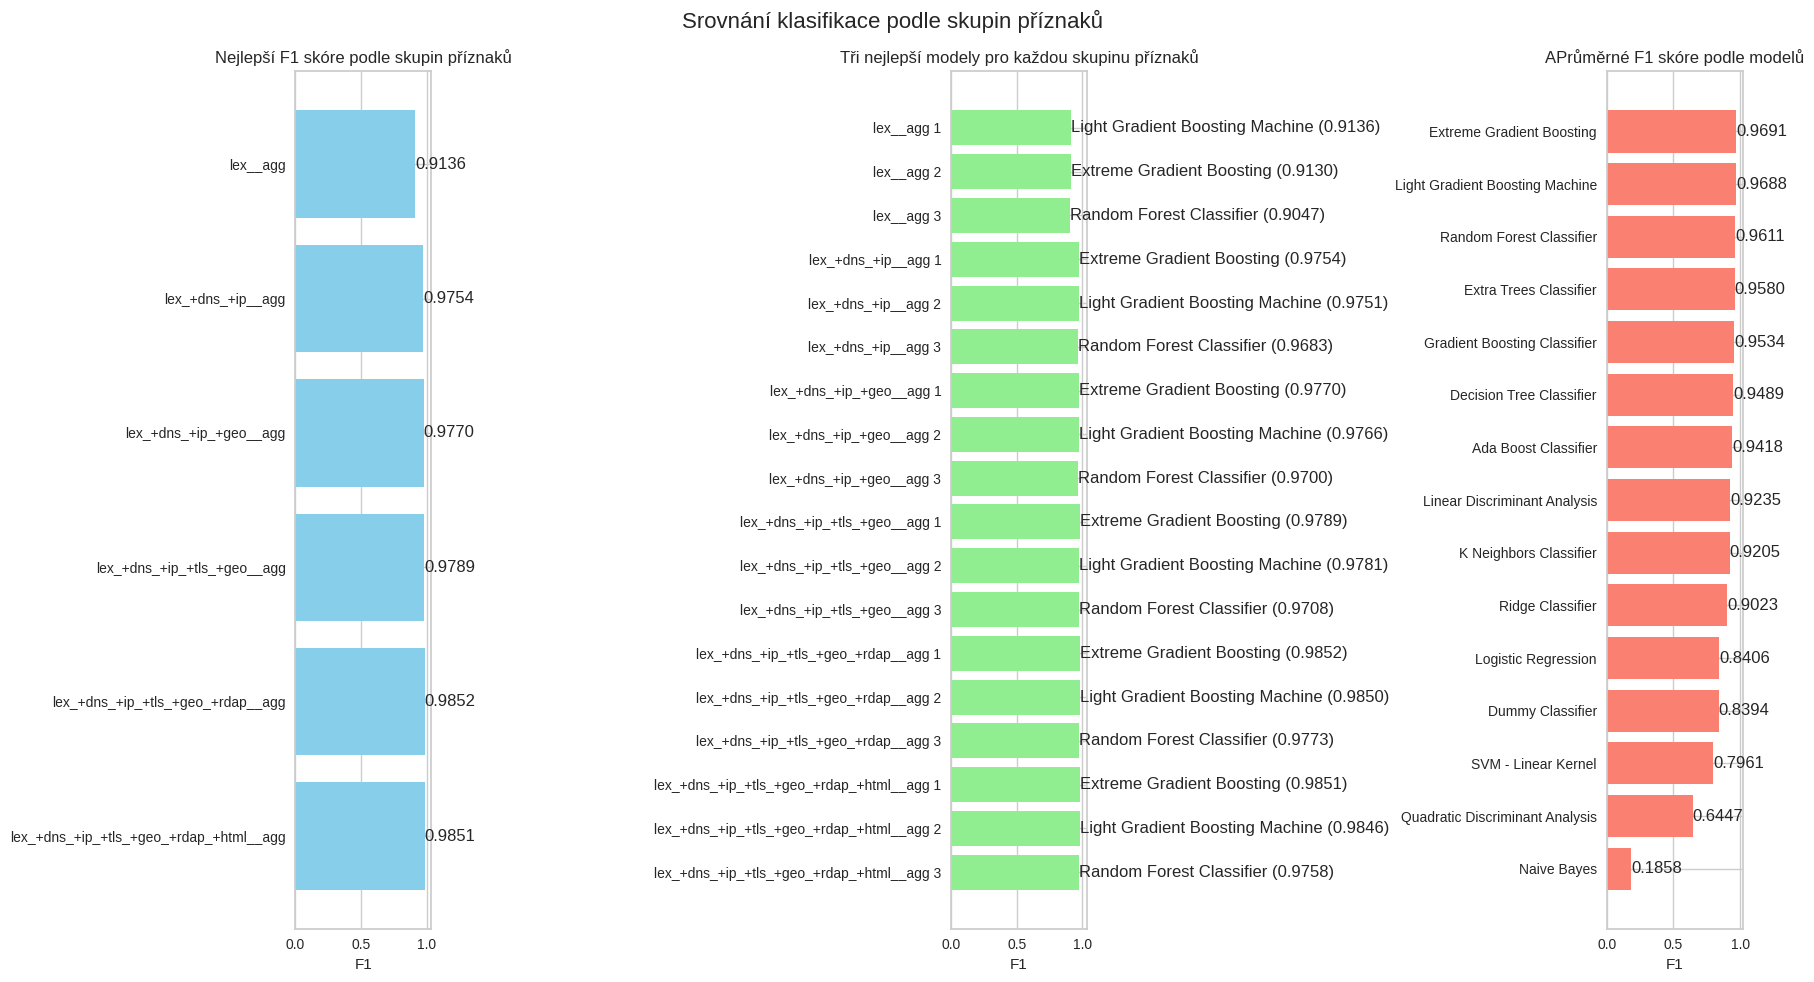

In [11]:
import matplotlib.pyplot as plt

# Extracting best F1 Scores and top models
best_f1_scores = []
model_names = []
subsets = []
top_models = {}

for prefix, grid in results_grids.items():
    # Best F1 score
    best_f1 = grid['F1'].max()
    best_f1_scores.append(best_f1)
    
    # Top 3 models
    top_3_models = grid.nlargest(3, 'F1')[['Model', 'F1']]
    top_models[prefix] = top_3_models
    model_names.append(top_3_models.iloc[0]['Model'])
    subsets = [s.replace('_html', '') for s in subsets]
    
    subsets.append(prefix)
    
# remove html from subsets


# Initialize figure
plt.figure(figsize=(18, 10))

# set header 
plt.suptitle('Srovnání klasifikace podle skupin příznaků', fontsize=16)

# Plot 1: Best F1 Scores by Feature Subset
plt.subplot(1, 3, 1)
bars = plt.barh(subsets, best_f1_scores, color='skyblue')
plt.xlabel('F1')
plt.title('Nejlepší F1 skóre podle skupin příznaků')
plt.gca().invert_yaxis()
# Annotate exact F1 scores
for bar, score in zip(bars, best_f1_scores):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

# Plot 2: Top Three Models for each Feature Subset
plt.subplot(1, 3, 2)
for i, (prefix, top_3) in enumerate(top_models.items()):
    for j, (index, row) in enumerate(top_3.iterrows()):
        plt.barh(f'{prefix} {j+1}', row['F1'], color='lightgreen')
        plt.text(row['F1'], i * 3 + j, f'{row["Model"]} ({row["F1"]:.4f})', va='center')
plt.title('Tři nejlepší modely pro každou skupinu příznaků')
plt.xlabel('F1')
plt.gca().invert_yaxis()

# Plot 3: Ranking of Models Across All Feature Sets
model_rankings = pd.concat([grid[['Model', 'F1']] for grid in results_grids.values()])
mean_f1_by_model = model_rankings.groupby('Model')['F1'].mean().sort_values(ascending=True)
plt.subplot(1, 3, 3)
bars = plt.barh(mean_f1_by_model.index, mean_f1_by_model, color='salmon')
plt.title('APrůměrné F1 skóre podle modelů')
plt.xlabel('F1')
# Annotate exact average F1 scores
for bar, score in zip(bars, mean_f1_by_model):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Using prefix:  lex_


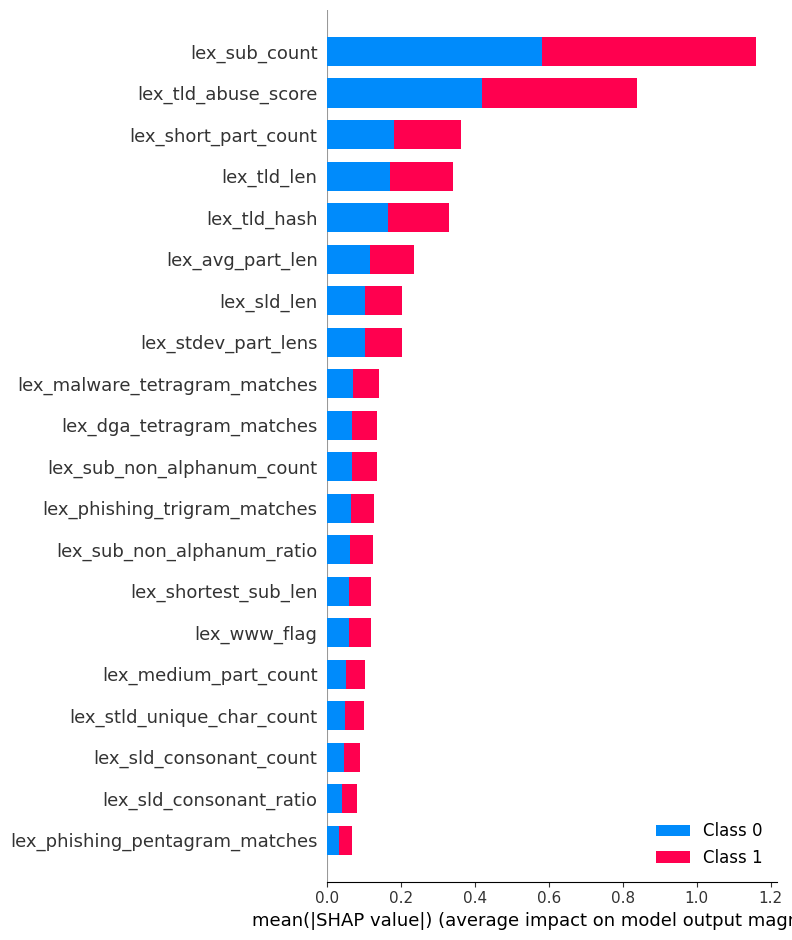

In [6]:
import shap
import matplotlib.pyplot as plt

#print all items in top3_models
#for key, value in top3_models.items():
    #print(key, value)
    
#subset = 'rdap_'

prefixes = ["lex_"]

for prefix in prefixes:

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(top3_models[prefix][0])

    # Compute SHAP values
    X = subset_dfs[prefix].drop('label', axis=1)
    shap_values = explainer.shap_values(X)

    # Summary plot (beeswarm)
    print("Using prefix: ", prefix)
    shap.summary_plot(shap_values, X)



# Combine models

For each subset, create blended model from top3 classifiers of this subset

In [ ]:
from pycaret.classification import *
import pandas as pd

def tune_and_stack_all_models():
    # Dictionary to store tuned models and their F1 scores for each subset
    all_tuned_models = {}
    all_f1_scores = {}

    # Iterate over each subset in subset_dfs
    for subset_name, subset_df in subset_dfs.items():
        print(f"\n🔍 Processing subset: {subset_name}")

        # PyCaret Setup
        clf = setup(subset_df, target='label', session_id=897, log_experiment=False, experiment_name=f'ensemble_tune_{subset_name}', index=False, use_gpu=True)

        # Retrieve top models stored for the subset
        top_models = top3_models[subset_name]

        # Stacking the top models
        blended_model = stack_models(estimator_list=top_models)

        # Tuning the blended model
        tuned_model = tune_model(blended_model, optimize='F1', n_iter=10)

        # Retrieve F1 score of the tuned model
        f1_score = pull().iloc[-1]['F1']

        # Saving the tuned model and F1 score
        model_name = f'tuned_{subset_name}'
        saved_model = save_model(tuned_model, model_name)
        all_tuned_models[subset_name] = saved_model
        all_f1_scores[subset_name] = f1_score

        print(f"✅ Tuned and saved model for '{subset_name}' with F1 Score: {f1_score:.4f}")

    # Save all_tuned_models and their F1 scores to pickle
    save_to_pickle(all_tuned_models, 'all_tuned_models.pickle')
    save_to_pickle(all_f1_scores, 'all_tuned_f1_scores.pickle')

    print("\n🔗 Final stacked model across all subsets created and saved.")
    return all_tuned_models

# Execute the function
final_model = tune_and_stack_all_models()



🔍 Processing subset: dns_
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training 

,Description,Value
0,Session id,897
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 41)"
5,Transformed data shape,"(18407, 41)"
6,Transformed train set shape,"(12884, 41)"
7,Transformed test set shape,"(5523, 41)"
8,Numeric features,39
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9131,0.8700,0.9131,0.9027,0.8987,0.4360,0.4741
1,0.9178,0.8747,0.9178,0.9085,0.9078,0.4976,0.5205
2,0.9185,0.9019,0.9185,0.9096,0.9080,0.4968,0.5228
3,0.9224,0.8893,0.9224,0.9153,0.9118,0.5153,0.5458
4,0.9138,0.9005,0.9138,0.9030,0.9021,0.4597,0.4863
5,0.9309,0.9191,0.9309,0.9260,0.9226,0.5764,0.6023
6,0.9208,0.8896,0.9208,0.9127,0.9103,0.5054,0.5334
7,0.9231,0.9053,0.9231,0.9157,0.9165,0.5519,0.5648
8,0.9193,0.8921,0.9193,0.9107,0.9086,0.4997,0.5269


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9123,0.8700,0.9123,0.9014,0.8981,0.4332,0.4697
1,0.9178,0.8740,0.9178,0.9085,0.9078,0.4976,0.5205
2,0.9185,0.9019,0.9185,0.9096,0.9080,0.4968,0.5228
3,0.9232,0.8892,0.9232,0.9162,0.9129,0.5220,0.5516
4,0.9138,0.9009,0.9138,0.9030,0.9021,0.4597,0.4863
5,0.9301,0.9192,0.9301,0.9248,0.9219,0.5732,0.5979
6,0.9208,0.8897,0.9208,0.9127,0.9103,0.5054,0.5334
7,0.9231,0.9048,0.9231,0.9157,0.9165,0.5519,0.5648
8,0.9177,0.8924,0.9177,0.9085,0.9073,0.4938,0.5186


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
✅ Tuned and saved model for 'dns_' with F1 Score: 0.0065

🔍 Processing subset: tls_
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built


,Description,Value
0,Session id,897
1,Target,label
2,Target type,Binary
3,Target mapping,"benign: 0, malware: 1"
4,Original data shape,"(18407, 25)"
5,Transformed data shape,"(18407, 25)"
6,Transformed train set shape,"(12884, 25)"
7,Transformed test set shape,"(5523, 25)"
8,Numeric features,23
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8891,0.7395,0.8891,0.9014,0.8391,0.0359,0.1351
1,0.8875,0.7062,0.8875,0.9002,0.8354,0.0121,0.0780
2,0.8867,0.7277,0.8867,0.8440,0.8364,0.0208,0.0681
3,0.8898,0.7113,0.8898,0.9020,0.8409,0.0476,0.1561
4,0.8905,0.7253,0.8905,0.8843,0.8433,0.0578,0.1560
5,0.8851,0.7367,0.8851,0.8103,0.8348,0.0059,0.0173
6,0.8882,0.7184,0.8882,0.8541,0.8406,0.0427,0.1073
7,0.8882,0.7329,0.8882,0.8568,0.8393,0.0327,0.0963
8,0.8866,0.7322,0.8866,0.8439,0.8363,0.0207,0.0681


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:20:54
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 1310, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1310, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1310, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1310, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1310, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1311, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1311, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number of positive: 1311, number of negative: 10285
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Number 

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have best_f1_scores and subsets from previous results
# Load the F1 scores of the tuned models
all_f1_scores = load_from_pickle('all_tuned_f1_scores.pickle')

# Data for plotting
original_f1 = best_f1_scores
tuned_f1 = [all_f1_scores[subset] for subset in subsets]

# Plotting
plt.figure(figsize=(12, 8))
x = range(len(subsets))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x, original_f1, width, label='Original Best F1', color='skyblue')
rects2 = ax.barh([p + width for p in x], tuned_f1, width, label='Tuned Blended F1', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('F1 Score')
ax.set_title('F1 Score Comparison by Subset')
ax.set_yticks([p + width / 2 for p in x])
ax.set_yticklabels(subsets)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()


In [ ]:
# combine all models into one ensemble model
from pycaret.classification import *

def combine_all_models():
    # load models from pickle

    
    final_stacked_model = stack_models(estimator_list=list(load_from_pickle('all_tuned_models.pickle').values()))

    # Saving the final stacked model
    save_model(final_stacked_model, 'final_stacked_model')